In [3]:
import collections
import glob
import itertools
import json
import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

In [4]:
import s3dexp.db

In [30]:
df = pd.read_sql(
    'SELECT t1.path, size, rand_read_ms FROM ImageMeta t1 JOIN DiskReadProfile t2 ON t1.path=t2.path', 
    s3dexp.db.engine)

In [31]:
df.head()

,path,size,rand_read_ms
0,/mnt/hdd/fast20/jpeg/flickr2500/0018efea055a5b...,51071,7.548809
1,/mnt/hdd/fast20/jpeg/flickr2500/00a203ffb7d3d5...,89774,4.564047
2,/mnt/hdd/fast20/jpeg/flickr2500/005b717bdb1151...,79589,9.124994
3,/mnt/hdd/fast20/jpeg/flickr2500/003c5a53bd2e6d...,84876,0.478983
4,/mnt/hdd/fast20/jpeg/flickr2500/006eee87ab62d0...,39755,9.356022


<IPython.core.display.Javascript object>


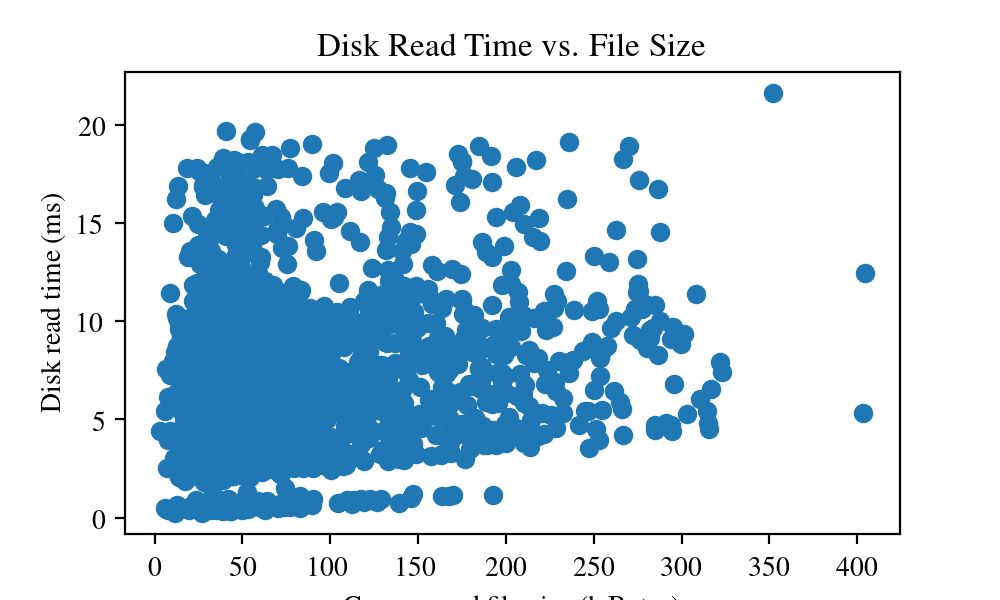

In [32]:
%matplotlib notebook

plt.figure(figsize=(5,3))
plt.scatter(df['size'] / 1024, df['rand_read_ms'])
plt.xlabel('Compressed file size (k Bytes)')
plt.ylabel('Disk read time (ms)')
plt.title('Disk Read Time vs. File Size')
plt.savefig('readtime-filesize.pdf', bbox_inches ='tight')